### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.svm import LinearSVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [2]:
df_run = pd.read_csv('data/RunData.csv')
df_inactive = pd.read_csv('data/InactivityData.csv')
df_walk = pd.read_csv('data/WalkData.csv')

In [3]:
df_run.head()

,-1528,1048,1536
0,-1232,520,512
1,-152,584,96
2,368,704,-104
3,664,712,-216
4,104,584,-248


### Shapes of Run, Inactive and Walk data

In [4]:
print('Shape of Run Dataset is ',df_run.shape)
print('Shape of Inactive Dataset is ',df_inactive.shape)
print('Shape of Walking Dataset is ',df_walk.shape)

Shape of Run Dataset is  (28399, 3)
Shape of Inactive Dataset is  (103499, 3)
Shape of Walking Dataset is  (144649, 3)


We can observe here that there is an imbalance in the number of observations for Run dataset as compared to the other two datasets.

### Normalizing the data

In [5]:
from sklearn import preprocessing

def normalize_df(df):
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df   

Since x,y and z values are in different scales, we normalize it to bring it to (0,1) scale

In [6]:
df_run = normalize_df(df_run)
df_inactive = normalize_df(df_inactive)
df_walk = normalize_df(df_walk)

### Adding Labels for each class

In [7]:
df_run['label'] = 1
df_inactive['label'] = 2
df_walk['label'] = 3

In [8]:
df_run.columns = ['x','y','z','label']
df_inactive.columns = ['x','y','z','label']
df_walk.columns = ['x','y','z','label']

In [9]:
df_walk.head()

,x,y,z,label
0,0.553592,0.562791,0.647887,3
1,0.550059,0.531783,0.617157,3
2,0.557126,0.513178,0.628681,3
3,0.572438,0.503876,0.640205,3
4,0.558304,0.485271,0.655570,3


### Plot of x, y, z axes for each Activity class

In [10]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, np.arange(0,data.shape[0]), data['x'], 'X-Axis')
    plot_axis(ax1, np.arange(0,data.shape[0]), data['y'], 'Y-Axis')
    plot_axis(ax2, np.arange(0,data.shape[0]), data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

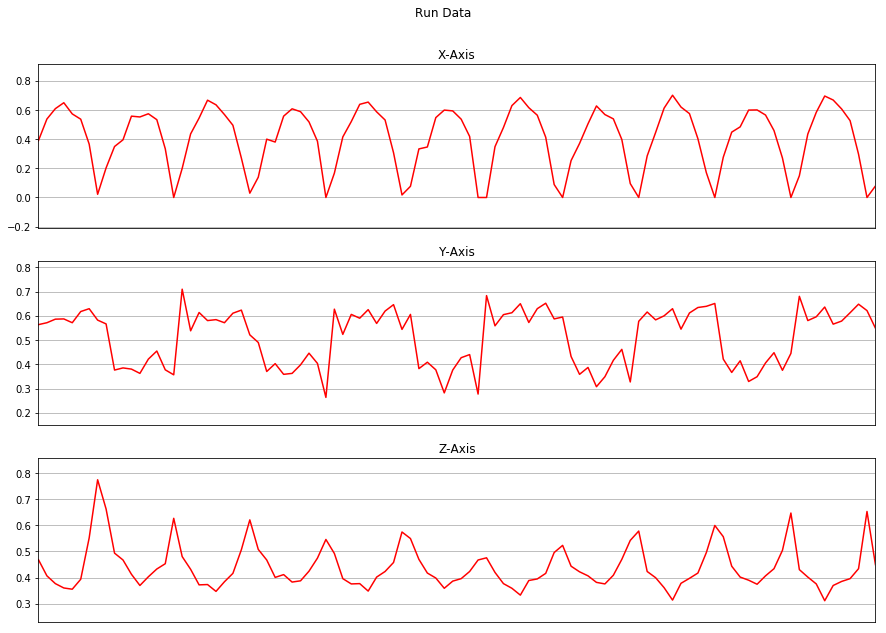

In [11]:
subset = df_run[:100]
plot_activity('Run Data', subset)

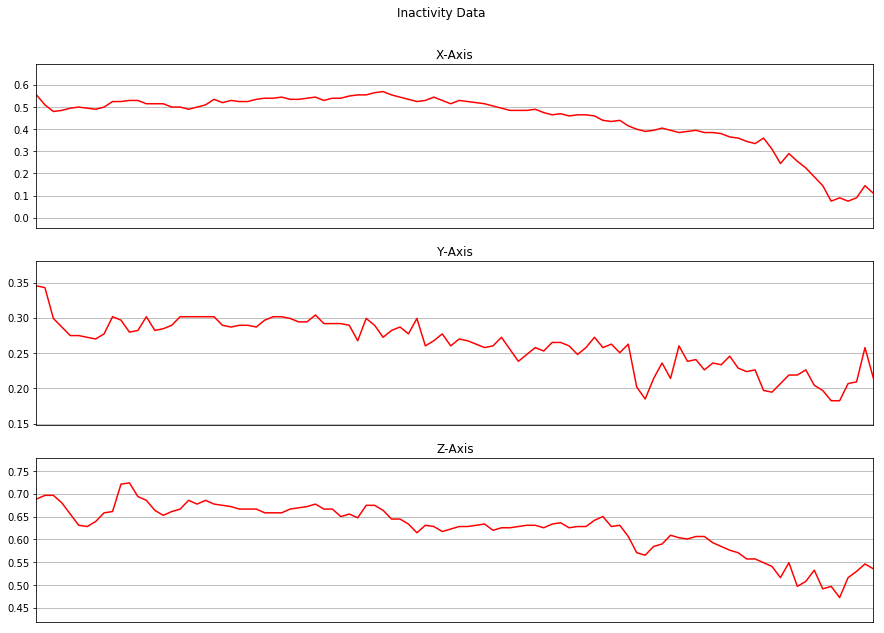

In [12]:
subset = df_inactive[:100]
plot_activity('Inactivity Data', subset)

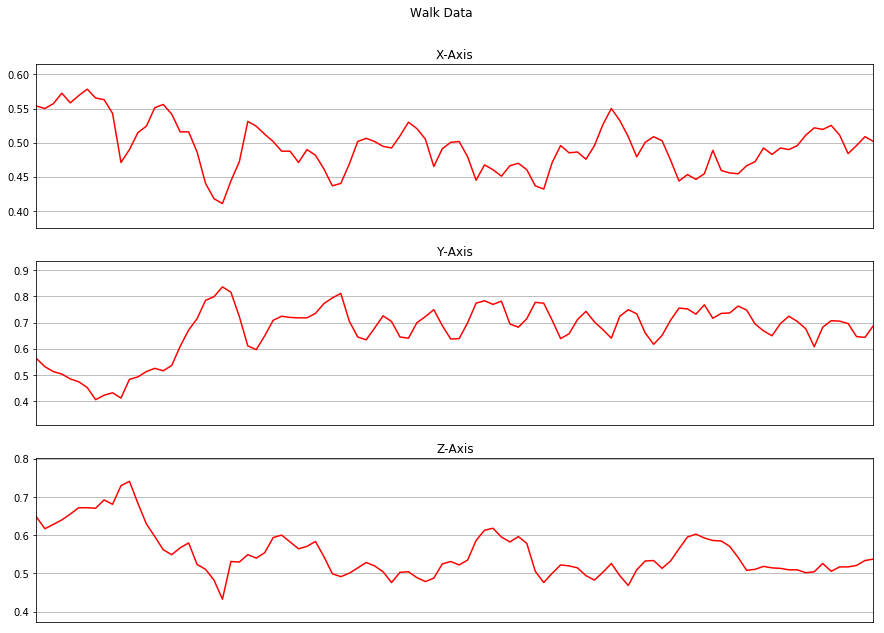

In [13]:
subset = df_walk[:100]
plot_activity('Walk Data', subset)

### Creating Time Series Data for every 2 seconds

In [14]:
def create_time_series_data(df):
    time_steps = 100
    segments = []
    step = 50
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]
        segments.append([xs, ys, zs])
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, 3)
    return reshaped_segments

The data is consolidated for every 2 seconds with 50 data points each (100 data pts. for 2 seconds) and with a sliding window of 50 data points

In [15]:
df_run_train = create_time_series_data(df_run)
df_inactive_train = create_time_series_data(df_inactive)
df_walk_train = create_time_series_data(df_walk)

In [16]:
print('Shape of Run Dataset after time slicing is ',df_run_train.shape)
print('Shape of Inactive Dataset after time slicing is ',df_inactive_train.shape)
print('Shape of Walking Dataset sfter time slicing is ',df_walk_train.shape)

Shape of Run Dataset after time slicing is  (566, 100, 3)
Shape of Inactive Dataset after time slicing is  (2068, 100, 3)
Shape of Walking Dataset sfter time slicing is  (2891, 100, 3)


### Creating new features from the time sliced data

In [17]:
def create_features(new_df,old_df,label):
    new_df['x_mean'] = np.array([np.mean(i) for i in old_df[:,0]])
    new_df['y_mean'] = np.array([np.mean(i) for i in old_df[:,1]])
    new_df['z_mean'] = np.array([np.mean(i) for i in old_df[:,2]])
    
    new_df['x_std'] = np.array([np.std(i) for i in old_df[:,0]])
    new_df['y_std'] = np.array([np.std(i) for i in old_df[:,1]])
    new_df['z_std'] = np.array([np.std(i) for i in old_df[:,2]])
    
    new_df['x_min'] = np.array([np.min(i) for i in old_df[:,0]])
    new_df['y_min'] = np.array([np.min(i) for i in old_df[:,1]])
    new_df['z_min'] = np.array([np.min(i) for i in old_df[:,2]])
    
    new_df['x_max'] = np.array([np.max(i) for i in old_df[:,0]])
    new_df['y_max'] = np.array([np.max(i) for i in old_df[:,1]])
    new_df['z_max'] = np.array([np.max(i) for i in old_df[:,2]])
    
    new_df['x_rms'] = np.array([np.sqrt(np.mean(i**2)) for i in old_df[:,0]])
    new_df['y_rms'] = np.array([np.sqrt(np.mean(i**2)) for i in old_df[:,1]])
    new_df['z_rms'] = np.array([np.sqrt(np.mean(i**2)) for i in old_df[:,2]])
    
    
    new_df['label'] = label
    
    return new_df

Features such as Mean, Standard Deviation, Minimum value, Maximum Value, Root Mean Square are being generated from the data

In [18]:
df_run_feats = pd.DataFrame()
df_inactive_feats = pd.DataFrame()
df_walk_feats = pd.DataFrame()

df_run_feats = create_features(df_run_feats,df_run_train,1)
df_inactive_feats = create_features(df_inactive_feats,df_inactive_train,2)
df_walk_feats = create_features(df_walk_feats,df_walk_train,3)

In [19]:
df_walk_feats.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,y_max,z_max,x_rms,y_rms,z_rms,label
0,0.553592,0.566549,0.568905,0.002885,0.006006,0.006732,0.550059,0.558304,0.563015,0.557126,0.572438,0.578327,0.553600,0.566581,0.568944,3
1,0.475461,0.459757,0.465646,0.023248,0.006755,0.003887,0.445230,0.451119,0.460542,0.501767,0.467609,0.469965,0.476029,0.459806,0.465662,3
2,0.453867,0.447585,0.449941,0.004337,0.024538,0.008655,0.448763,0.416961,0.439340,0.459364,0.477032,0.460542,0.453888,0.448258,0.450024,3
3,0.443659,0.468394,0.454653,0.009729,0.006823,0.009174,0.429918,0.459364,0.444052,0.451119,0.475854,0.466431,0.443766,0.468444,0.454745,3
4,0.448763,0.469572,0.467216,0.010579,0.006403,0.008179,0.435807,0.460542,0.457008,0.461720,0.474676,0.477032,0.448888,0.469616,0.467288,3


### Concatenating all data

In [20]:
df_final = pd.concat([df_run_feats,df_inactive_feats,df_walk_feats])
df_final.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,y_max,z_max,x_rms,y_rms,z_rms,label
0,0.512792,0.586988,0.197003,0.091338,0.047088,0.140620,0.390351,0.537281,0.021930,0.609649,0.650219,0.366228,0.520863,0.588874,0.242042,1
1,0.318713,0.276316,0.644371,0.230492,0.202634,0.030286,0.000000,0.000000,0.616228,0.537281,0.480263,0.686404,0.393325,0.342653,0.645083,1
2,0.441520,0.572003,0.139620,0.069258,0.043348,0.195904,0.380482,0.510965,0.000000,0.538377,0.607456,0.416667,0.446919,0.573643,0.240566,1
3,0.453947,0.221857,0.544591,0.127272,0.193632,0.063321,0.286184,0.012061,0.455044,0.594298,0.479167,0.589912,0.471451,0.294472,0.548259,1
4,0.506944,0.591740,0.170687,0.110582,0.082260,0.122167,0.359649,0.500000,0.046053,0.626096,0.699561,0.336623,0.518865,0.597430,0.209902,1


### Plot of Distribution of each Activity Label

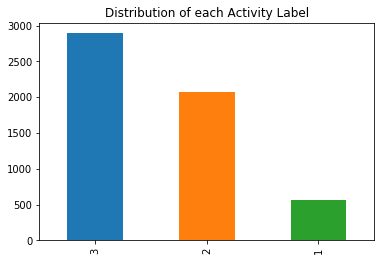

In [21]:
df_final['label'].value_counts().plot(kind='bar',
                                   title='Distribution of each Activity Label')
plt.show()

### Shuffling the data

In [22]:
df_final = df_final.sample(frac=1).reset_index(drop=True)

In [23]:
df_final_features = df_final.drop(['label'],axis=1)
df_final_labels = df_final['label']

### Train Test Split of Data

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(df_final_features, df_final_labels,
                                                   stratify = df_final_labels,test_size=0.3)

In [25]:
def metric_scores(y_test,pred):
    print("The labels are in the following order ['Run','Inactive','Walk']")
    print('F1 Score for the 3 classes is ',f1_score(y_test,pred,average = None))
    print('Precision Score for the 3 classes is ',precision_score(y_test,pred,average = None))
    print('Recall Score for the 3 classes is ',recall_score(y_test,pred,average = None))
    print('Accuracy Score for the 3 classes is ',accuracy_score(y_test,pred))

### Shape of Training and Test data

In [26]:
print('Shape of Training data is ',x_train.shape)
print('Shape of Test data is ',x_test.shape)

Shape of Training data is  (3867, 15)
Shape of Test data is  (1658, 15)


In [27]:
def confusion_matrix_plot(y_test,pred):
    ax = plt.axes()
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))
    sns.heatmap(df_bow, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    ax.xaxis.set_ticklabels(['Run', 'Inactive','Walk'])
    ax.yaxis.set_ticklabels(['Run', 'Inactive','Walk'])
    print(confusion_matrix(y_test,pred))

### Hyperparameter Tuning for Linear SVM using Grid Search

In [28]:
lr_svc = LinearSVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.05,0.01,0.1,1,5,10,100,500]
param_grid = {'C':C_list,'penalty':['l2']}
grid_search = GridSearchCV(lr_svc,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.05, 0.01, 0.1, 1, 5, 10, 100, 500], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [29]:
lr_svc_optimal = LinearSVC(C = grid_search.best_params_.get('C')
                                ,penalty = grid_search.best_params_.get('penalty'))
lr_svc_optimal.fit(x_train, y_train)
pred = lr_svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [30]:
print('The best Hyperparameters were')
print('C : ',grid_search.best_params_.get('C'))

The best Hyperparameters were
C :  1


### Performance Metrics for each Label

In [31]:
metric_scores(y_test,pred)

The labels are in the following order ['Run','Inactive','Walk']
F1 Score for the 3 classes is  [0.78169014 0.88506646 0.89218483]
Precision Score for the 3 classes is  [0.97368421 0.86018237 0.88261851]
Recall Score for the 3 classes is  [0.65294118 0.91143317 0.90196078]
Accuracy Score for the 3 classes is  0.8799758745476478


### Confusion Matrix plot for each label

[[111   8  51]
 [  2 566  53]
 [  1  84 782]]


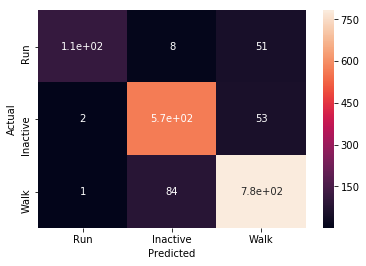

In [32]:
confusion_matrix_plot(y_test,pred)